## Week 2: Diving deeper into the BBC News archive

BBC News Classification Dataset
* 2225 examples of new articles with their respective categories (labels).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt
import numpy as np
import csv
import re 
import string

In [2]:
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
SEQUENCE_LENGTH = 120
OOV_TOKEN = '[UNK]'
TRAINING_SPLIT = .8

In [3]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [4]:
def parse_data_from_file(filename):

    sentences = []
    labels = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        for row in reader:
            sentences.append(row[1])
            labels.append(row[0])

    return sentences, labels

In [5]:
dataset_path = '../../../data/bbc-text.csv'
sentences, labels = parse_data_from_file(dataset_path)

In [6]:
def train_val_split(sentences, labels, training_split):

    train_size = int(len(sentences) * training_split)

    train_sentences = sentences[:train_size]
    y_train = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, y_train, validation_labels

In [7]:
train_sentences, val_sentences, y_train, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"{len(train_sentences)} sentences for training.")
print(f"{len(val_sentences)} sentences for validation.")

1780 sentences for training.
445 sentences for validation.


In [8]:
def custom_standardization(input_data):
    
    text = tf.strings.lower(input_data)
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), ' ')

    for word in stopwords:
        text = tf.strings.regex_replace(text, rf'\b{word}\b', '')

    return text

In [9]:
classes = {label: i for i, label in enumerate(set((y_train)))}

y_train = [[classes[label]] for label in y_train]
val_labels = [[classes[label]] for label in val_labels]

raw_train_ds = tf.data.Dataset.from_tensor_slices((train_sentences, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))

In [10]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_sequence_length=SEQUENCE_LENGTH)

vectorize_layer.adapt(train_sentences)

In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [12]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [13]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [14]:
def create_model(vocab_size, embedding_dim, sequence_length):

    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(5)])

    model.compile(optimizer='adam',
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.9:
            print('\nReached 95% accuracy and 90% validation accuracy so cancelling training!')
            self.model.stop_training = True

callback = myCallback()

In [16]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, SEQUENCE_LENGTH)
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[callback])

Epoch 1/30
1780/1780 [==============================] - 13s 6ms/step - loss: 1.4364 - accuracy: 0.5146 - val_loss: 1.1552 - val_accuracy: 0.8180
Epoch 2/30
1780/1780 [==============================] - 12s 7ms/step - loss: 0.8404 - accuracy: 0.8826 - val_loss: 0.6182 - val_accuracy: 0.9371
Epoch 3/30
1780/1780 [==============================] - 11s 6ms/step - loss: 0.4509 - accuracy: 0.9494 - val_loss: 0.3773 - val_accuracy: 0.9393
Epoch 4/30
1773/1780 [============================>.] - ETA: 0s - loss: 0.2778 - accuracy: 0.9645
Reached 95% accuracy and 90% validation accuracy so cancelling training!
1780/1780 [==============================] - 11s 6ms/step - loss: 0.2779 - accuracy: 0.9640 - val_loss: 0.2723 - val_accuracy: 0.9461


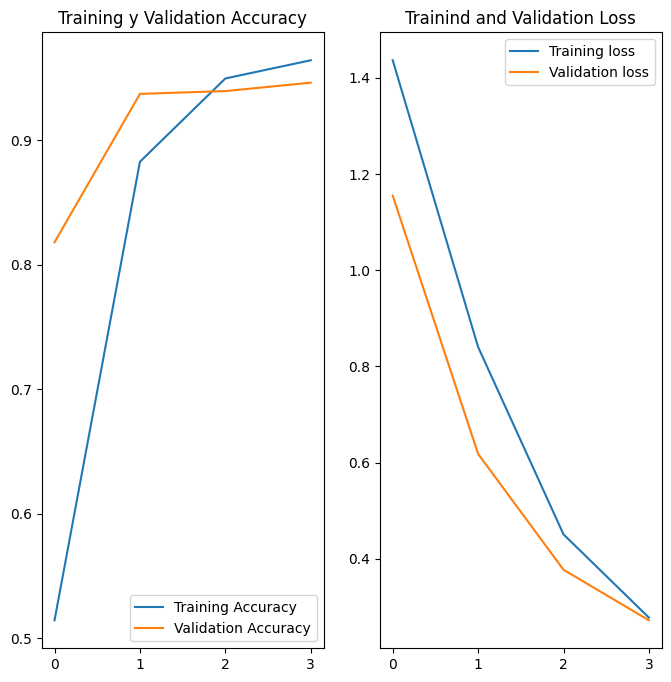

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()